https://github.com/znxlwm/pytorch-pix2pix
https://arxiv.org/abs/1611.07004

## Set up For colab

In [0]:
!rm -rf pix2pix-scratch-master

In [0]:
# from google.colab import files
# files.upload()

!pip install torch torchvision imageio

# !wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
# !tar -xzf "facades.tar.gz"
# !mkdir data
# !mv facades data/facades

!wget https://github.com/aiywatch/pix2pix-scratch/archive/master.zip
!unzip master.zip
!rm -rf master.zip


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os, time, pickle, argparse#, util
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
# from PIL.Image import imread

import matplotlib.pyplot as plt

In [0]:
import sys

sys.argv = ['train.py', ]

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=False, default='facades',  help='')
parser.add_argument('--train_subfolder', required=False, default='train',  help='')
parser.add_argument('--test_subfolder', required=False, default='val',  help='')
parser.add_argument('--batch_size', type=int, default=1, help='train batch size')
parser.add_argument('--test_batch_size', type=int, default=5, help='test batch size')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--input_size', type=int, default=256, help='input size')
parser.add_argument('--crop_size', type=int, default=256, help='crop size (0 is false)')
parser.add_argument('--resize_scale', type=int, default=286, help='resize scale (0 is false)')
parser.add_argument('--fliplr', type=bool, default=True, help='random fliplr True or False')
parser.add_argument('--train_epoch', type=int, default=200, help='number of train epochs')
parser.add_argument('--lrD', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--lrG', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--L1_lambda', type=float, default=100, help='lambda for L1 loss')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--save_root', required=False, default='results', help='results save path')
parser.add_argument('--inverse_order', type=bool, default=True, help='0: [input, target], 1 - [target, input]')
opt = parser.parse_args()
print(opt)

Namespace(L1_lambda=100, batch_size=1, beta1=0.5, beta2=0.999, crop_size=256, dataset='facades', fliplr=True, input_size=256, inverse_order=True, lrD=0.0002, lrG=0.0002, ndf=64, ngf=64, resize_scale=286, save_root='results', test_batch_size=5, test_subfolder='val', train_epoch=200, train_subfolder='train')


In [0]:
import scipy
from skimage.color import gray2rgb
import numpy as np
from skimage.transform import resize

class NucleiDataset(Dataset):
  
#   NAME_TO_ID = {'cropped_John_data': 1., 'MICCAI': 2.}
  NAME_TO_ID = {}

  def __init__(self, root_dir, dataset_lists, transform=None, mode='train'):
    self.root_dir = root_dir
    self.dataset_lists = dataset_lists
    self.transform = transform
    self.mode = mode
    
    self.file_names = []
    for dataset in dataset_lists:
      
      file_names = next(os.walk(root_dir+f'{dataset}/trainA/{self.mode}/'))[2]
      
#       if mode == 'train':
#         file_names = np.random.choice(file_names, 29, replace=False)
      
      file_and_dataset = [(dataset, file_name) for file_name in file_names]
      
      self.file_names.extend(file_and_dataset)
      
    for id, dataset in enumerate(dataset_lists):
      self.NAME_TO_ID[dataset] = id + 1.

  def __len__(self):
    return len(self.file_names)

  def __getitem__(self, idx):
    
    dataset, file_name = self.file_names[idx]
    
    mask_path = os.path.join(self.root_dir, f'{dataset}/trainA/{self.mode}/', file_name)
    img_path = os.path.join(self.root_dir, f'{dataset}/trainB/{self.mode}/',  file_name)
    
    dataset_id = self.NAME_TO_ID[dataset]
    
    mask = imread(mask_path)
    mask = resize(mask, (256, 256))
    mask = torch.Tensor(mask).view(-1, 256, 256)
    label_layer = torch.ones((1, mask.shape[1], mask.shape[2])) * dataset_id
    mask = torch.cat([mask, label_layer], 0)
    
    
    image = imread(img_path)[:,:,:3]
    
    if self.transform:
      image = self.transform(image)
    
    
    return mask, image, dataset_id

In [0]:
transform = transforms.Compose([
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        transforms.ToPILImage(mode=None),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    
])

dataset = NucleiDataset('pix2pix-scratch-master/data/', ['cropped_John_data', 'MICCAI'], transform)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

dataset_test = NucleiDataset('pix2pix-scratch-master/data/', ['cropped_John_data', 'MICCAI'], transform, 'test')

In [0]:
class generator(nn.Module):
  # initializers
  def __init__(self, d=64):
    super(generator, self).__init__()
    # Unet encoder
    self.conv1 = nn.Conv2d(2, d, 4, 2, 1)
    self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(d * 2)
    self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(d * 4)
    self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
    self.conv4_bn = nn.BatchNorm2d(d * 8)
    self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
    self.conv5_bn = nn.BatchNorm2d(d * 8)
    self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
    self.conv6_bn = nn.BatchNorm2d(d * 8)
    self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
    self.conv7_bn = nn.BatchNorm2d(d * 8)
    self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
#     self.conv8_bn = nn.BatchNorm2d(d * 8)
    

    # Unet decoder
    self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
    self.deconv1_bn = nn.BatchNorm2d(d * 8)
    self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
    self.deconv2_bn = nn.BatchNorm2d(d * 8)
    self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
    self.deconv3_bn = nn.BatchNorm2d(d * 8)
    self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
    self.deconv4_bn = nn.BatchNorm2d(d * 8)
    self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
    self.deconv5_bn = nn.BatchNorm2d(d * 4)
    self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
    self.deconv6_bn = nn.BatchNorm2d(d * 2)
    self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
    self.deconv7_bn = nn.BatchNorm2d(d)
    self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    
    
    
    e1 = self.conv1(input)
    e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
    e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
    e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
    e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
    e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
    e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
    e8 = self.conv8(F.leaky_relu(e7, 0.2))
    # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))
    

  
    d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
    d1 = torch.cat([d1, e7], 1)
    d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
    d2 = torch.cat([d2, e6], 1)
    d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
    d3 = torch.cat([d3, e5], 1)
    d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
    # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
    d4 = torch.cat([d4, e4], 1)
    d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
    d5 = torch.cat([d5, e3], 1)
    d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
    d6 = torch.cat([d6, e2], 1)
    d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
    d7 = torch.cat([d7, e1], 1)
    d8 = self.deconv8(F.relu(d7))
    o = F.tanh(d8)
    
    
#     print('input', input.shape)
#     print('conv1', e1.shape)
#     print('conv2', e2.shape)
#     print('conv3', e3.shape)
#     print('conv4', e4.shape)
#     print('conv5', e5.shape)
#     print('conv6', e6.shape)
#     print('conv7', e7.shape)
#     print('conv8', e8.shape)
#     print('dconv1', d1.shape)
#     print('dconv2', d2.shape)
#     print('dconv3', d3.shape)
#     print('dconv4', d4.shape)
#     print('dconv5', d5.shape)
#     print('dconv6', d6.shape)
#     print('dconv7', d7.shape)
#     print('dconv8', d8.shape)

    return o

  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features
  
class discriminator(nn.Module):
  # initializers
  def __init__(self, d=64):
    super(discriminator, self).__init__()
    self.conv1 = nn.Conv2d(5, d, 4, 2, 1)
    self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(d * 2)
    self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(d * 4)
    self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
    self.conv4_bn = nn.BatchNorm2d(d * 8)
    self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input, label):
    x = torch.cat([input, label], 1)
#     print(x.shape)
    x = F.leaky_relu(self.conv1(x), 0.2)
#     print(x.shape)
    x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
#     print(x.shape)
    x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
#     print(x.shape)
    x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
#     print(x.shape)
    x = F.sigmoid(self.conv5(x))
#     print(x.shape)
#     print('END')

    
    
    return x

def normal_init(m, mean, std):
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()

In [0]:
# network
G = generator(opt.ngf)
D = discriminator(opt.ndf)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()
G.train()
D.train()

# loss
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=opt.lrG, betas=(opt.beta1, opt.beta2))
D_optimizer = optim.Adam(D.parameters(), lr=opt.lrD, betas=(opt.beta1, opt.beta2))

In [0]:
for epoch in range(100):

  for x_, y_, opt_ in train_loader:
    # train discriminator D
    
    D.zero_grad()
    
    x_, y_= Variable(x_.cuda()), Variable(y_.cuda())

    D_result = D(x_, y_).squeeze()
    
    D_real_loss = BCE_loss(D_result, Variable(torch.ones(D_result.size()).cuda()))
#     print(D_result)

    G_result = G(x_)
    D_result = D(x_, G_result).squeeze()
    D_fake_loss = BCE_loss(D_result, Variable(torch.zeros(D_result.size()).cuda()))

    D_train_loss = (D_real_loss + D_fake_loss) * 0.5
    D_train_loss.backward()
    D_optimizer.step()


    
    # train generator G
    G.zero_grad()

    G_result = G(x_)
    D_result = D(x_, G_result).squeeze()

    G_train_loss = BCE_loss(D_result, Variable(torch.ones(D_result.size()).cuda())) + opt.L1_lambda * L1_loss(G_result, y_)
    G_train_loss.backward()
    G_optimizer.step()
  

#   break
  print(f'epoch: {epoch} finished')

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0 finished
epoch: 1 finished
epoch: 2 finished
epoch: 3 finished
epoch: 4 finished
epoch: 5 finished
epoch: 6 finished
epoch: 7 finished
epoch: 8 finished
epoch: 9 finished
epoch: 10 finished
epoch: 11 finished
epoch: 12 finished
epoch: 13 finished
epoch: 14 finished
epoch: 15 finished
epoch: 16 finished
epoch: 17 finished
epoch: 18 finished
epoch: 19 finished
epoch: 20 finished
epoch: 21 finished
epoch: 22 finished
epoch: 23 finished
epoch: 24 finished
epoch: 25 finished
epoch: 26 finished


KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


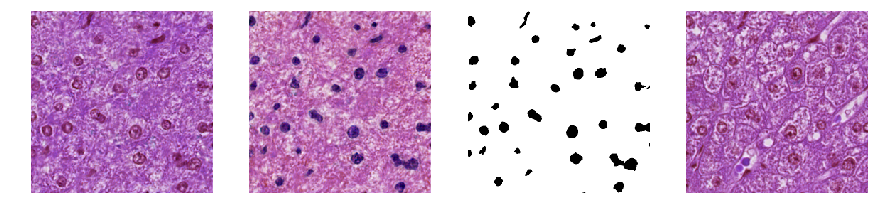

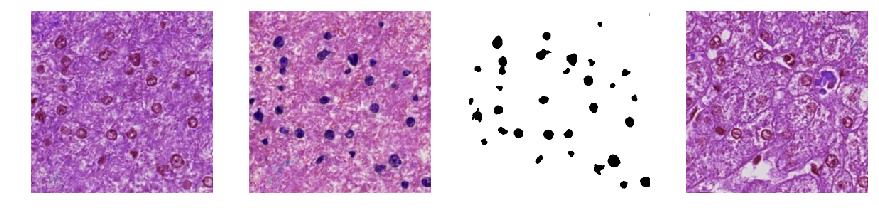

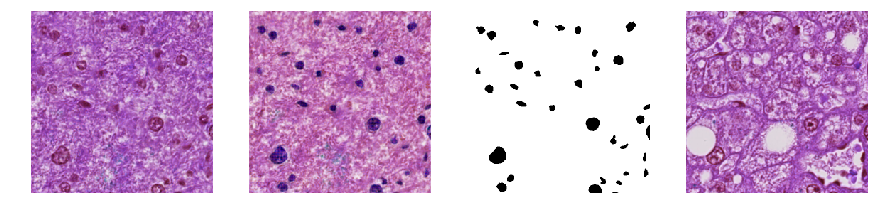

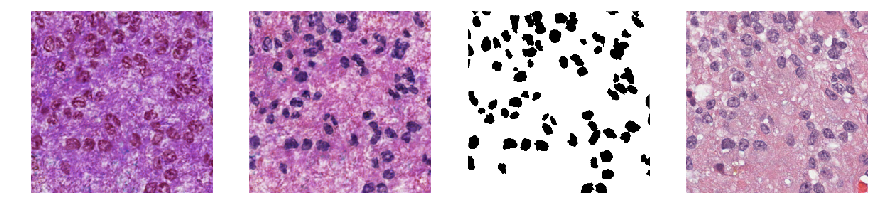

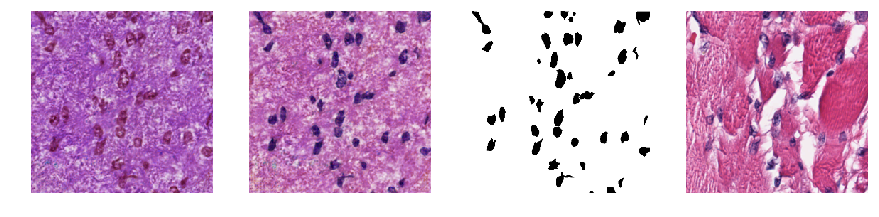

In [0]:
for mask, image, _ in dataset_test:

  
  option_layer1 = torch.ones((1, mask.shape[1], mask.shape[2]))
  option_layer2 = torch.ones((1, mask.shape[1], mask.shape[2])) * 2
  
  mask1 = torch.cat([mask[:1], option_layer1], 0)
  mask2 = torch.cat([mask[:1], option_layer2], 0)
#   print(mask1.shape)
  
  out1 = G(mask1.view(1,2,256,256).cuda())[0,:,:,:].permute(1,2,0).cpu().detach().numpy()
  out1[out1<0] = 0
  
  out2 = G(mask2.view(1,2,256,256).cuda())[0,:,:,:].permute(1,2,0).cpu().detach().numpy()
  out2[out2<0] = 0

  plt.figure(figsize=(15,15))
  plt.subplot(141)
  plt.imshow(out1)
  plt.axis('off')
  plt.grid(False)
  plt.subplot(142)
  plt.imshow(out2)
  plt.axis('off')
  plt.grid(False)
  plt.subplot(143)
  plt.imshow(mask[0])
  plt.axis('off')
  plt.grid(False)
  plt.subplot(144)
  plt.imshow(image.permute(1,2,0))
  plt.axis('off')
  plt.grid(False)
  plt.show()

In [0]:
class GenNucleiDataset(Dataset):

  def __init__(self, root_dir, transform=None, mode='train'):
    self.root_dir = root_dir
    self.transform = transform
    self.file_names = next(os.walk(root_dir))[2]

  def __len__(self):
    return len(self.file_names)

  def __getitem__(self, idx):
    mask_path = os.path.join(self.root_dir, self.file_names[idx])
    
    mask = imread(mask_path)
    mask = resize(mask, (256, 256))
    mask = torch.Tensor(mask).view(-1, 256, 256)
    
    
#     mask = gray2rgb(mask)
    
#     if self.transform:
#       mask = self.transform(mask)

    return mask

dataset_gen = GenNucleiDataset('generated_mask/', transform)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


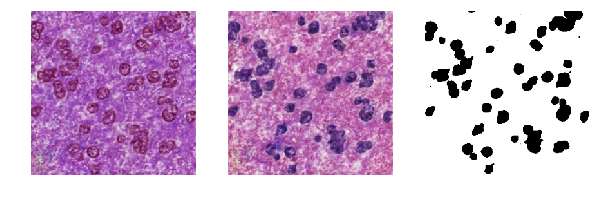

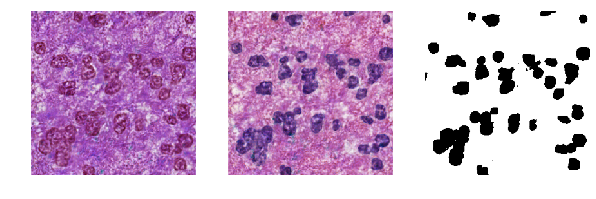

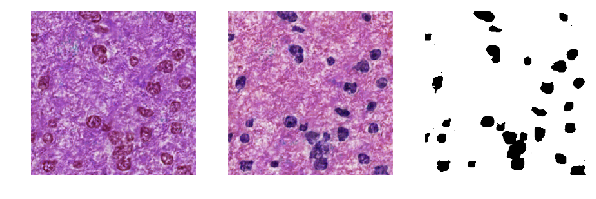

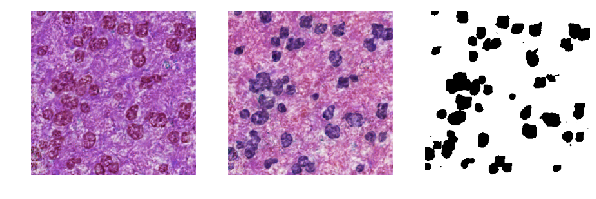

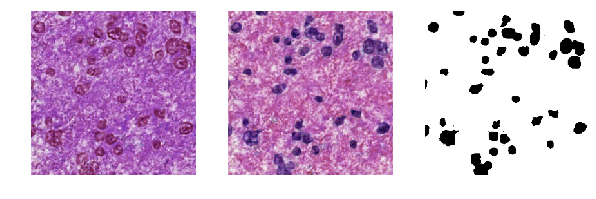

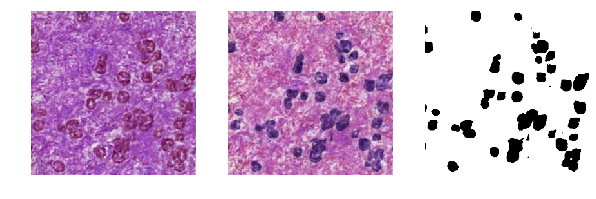

In [0]:
for mask in dataset_gen:
  
  
  option_layer1 = torch.ones((1, mask.shape[1], mask.shape[2]))
  option_layer2 = torch.ones((1, mask.shape[1], mask.shape[2])) * 2
  
  mask1 = torch.cat([mask, option_layer1], 0)
  mask2 = torch.cat([mask, option_layer2], 0)
  
  out1 = G(mask1.view(1,2,256,256).cuda())[0,:,:,:].permute(1,2,0).cpu().detach().numpy()
  out1[out1<0] = 0
  
  out2 = G(mask2.view(1,2,256,256).cuda())[0,:,:,:].permute(1,2,0).cpu().detach().numpy()
  out2[out2<0] = 0

  plt.figure(figsize=(10,10))
  plt.subplot(131)
  plt.imshow(out1)
  plt.axis('off')
  plt.grid(False)
  plt.subplot(132)
  plt.imshow(out2)
  plt.axis('off')
  plt.grid(False)
  plt.subplot(133)
  plt.imshow(mask[0])
  plt.axis('off')
  plt.grid(False)
  plt.show()

In [0]:
torch.save(G, './G_model.pth')
torch.save(D, './D_model.pth')

from google.colab import files

files.download('./G_model.pth')
files.download('./D_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 35796, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.Reques

In [0]:
!ls

datalab      dvae_model      G_model.pth
D_model.pth  generated_mask  pix2pix-scratch-master


In [0]:
# from google.colab import files
# files.upload()


G2 = generator(opt.ngf)
D2 = discriminator(opt.ndf)

G2 = torch.load('./G_model.pth')
D2 = torch.load('./D_model.pth')